In [2]:
from TexSoup import TexSoup
from TexSoup import read as TexRead
from TexSoup.data import BraceGroup
import networkx as nx
import shutil
import os
import re
from pathlib import Path

In [3]:
with open("src/ms.tex", 'r') as f:
    contents = f.read()

In [4]:
soup = TexSoup(contents)

In [5]:
soup.documentclass.args

[BracketGroup('twocolumn,linenumbers'), BraceGroup('src/aastex631')]

In [6]:
def parse_and_add_nodes(file, g, nodeFilters):
    g.nodes[file]['complete'] = True
    filterFunc = lambda node: list(filter(lambda x: type(x)==BraceGroup, node.args))[0].contents[0]
    with open(file, 'r') as f:
        contents = f.read()
    soup = TexSoup(contents)
    for nodeType in nodeFilters:
        nodeElements = soup.find_all(nodeType)
        tex = True if nodeType in ['input', 'include'] else False
        for node in nodeElements:
            nodeContent = filterFunc(node)
            g.add_node(nodeContent, tex=tex, nodeType=nodeType, complete=False)
            g.add_edge(file, nodeContent)
        
    # Recursive calls for sub-nodes
    for nodeName in [x for x,y in g.nodes(data=True) if y['nodeType'] in ['input', 'include']]:
        if not g.nodes[nodeName]['complete'] and g.nodes[nodeName]['tex']:
            print(f"Working in {nodeName}")
            parse_and_add_nodes(nodeName, g, nodeFilters)

    # Set 'complete' to True after processing all sub-nodes

In [7]:
nodeFilters = [
    "input",
    "include",
    "documentclass",
    "bibliography",
    "includegraphics"
]

In [8]:
def traverse_tex_tree(file, nodeFilters):
    G = nx.DiGraph()
    G.add_node(file, complete=True, tex=True, nodeType='root')
    parse_and_add_nodes(file, G, nodeFilters)
    return G

In [9]:
G = traverse_tex_tree("src/ms.tex", nodeFilters)

Working in src/sections/intro.tex
Working in src/sections/AtmopshericModels.tex
Working in src/sections/modeling.tex
Working in src/sections/fidanka.tex
Working in src/sections/fitting.tex
Working in src/sections/conclusion.tex


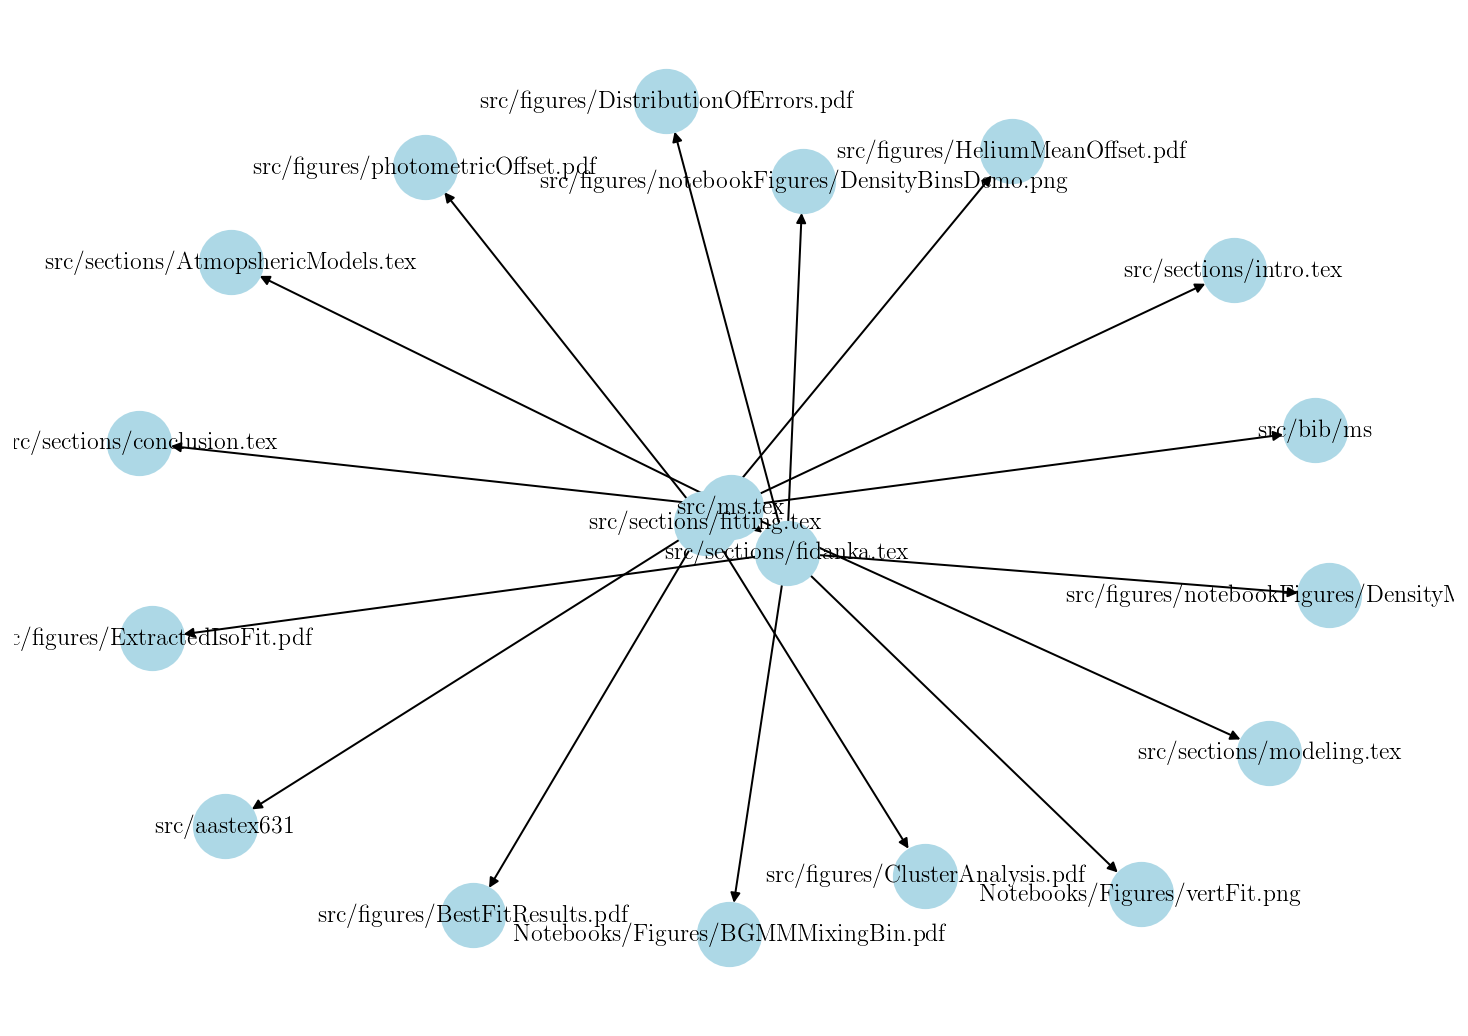

In [11]:
labels = {node: node for node in G.nodes()}

# Draw the graph
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, labels=labels, node_color='lightblue', font_size=12, node_size=1000)

In [240]:
for edge in nx.bfs_edges(G, source="src/ms.tex"):
    print(edge)

('src/ms.tex', 'src/sections/intro.tex')
('src/ms.tex', 'src/sections/AtmopshericModels.tex')
('src/ms.tex', 'src/sections/modeling.tex')
('src/ms.tex', 'src/sections/fidanka.tex')
('src/ms.tex', 'src/sections/fitting.tex')
('src/ms.tex', 'src/sections/conclusion.tex')
('src/sections/fidanka.tex', 'src/figures/notebookFigures/DensityMapDemo.png')
('src/sections/fidanka.tex', 'src/figures/notebookFigures/DensityBinsDemo.png')
('src/sections/fidanka.tex', 'Notebooks/Figures/BGMMMixingBin.pdf')
('src/sections/fidanka.tex', 'Notebooks/Figures/vertFit.png')
('src/sections/fidanka.tex', 'src/figures/ExtractedIsoFit.pdf')
('src/sections/fidanka.tex', 'src/figures/DistributionOfErrors.pdf')
('src/sections/fitting.tex', 'src/figures/BestFitResults.pdf')
('src/sections/fitting.tex', 'src/figures/ClusterAnalysis.pdf')
('src/sections/fitting.tex', 'src/figures/photometricOffset.pdf')
('src/sections/fitting.tex', 'src/figures/HeliumMeanOffset.pdf')


In [332]:
def flatten_dirstructure(originator, newFolder):
    if os.path.exists(newFolder):
        shutil.rmtree(newFolder)
    os.mkdir(newFolder)
    G = traverse_tex_tree(originator) 

In [472]:
class TexProjectFormatter:
    def __init__(self, originator, basePath, force=False):
        self.iwd = os.getcwd()
        self.originator = originator
        self.projectGraph = traverse_tex_tree(originator)
        self._filerefs = dict()
        self.basePath = basePath
        
        if os.path.exists(basePath):
            if force:
                shutil.rmtree(basePath)
                os.makedirs(basePath)
            else:
                raise OSError(f"Folder {basePath} exists!")
        else:
            os.makedirs(basePath)
    
    def flatten(self):
        basePattern = lambda x: x
        patterns = {
            'bib' : lambda x: x + "(?:.bib)?",
            'documentclass': lambda x : x + "(?:.cls|.class)?"
        }
        for nodeName, nodeData in self.projectGraph.nodes(data=True):
            filename = os.path.basename(nodeName)
            newPath = os.path.join(self.basePath, filename)
            if not nodeData.get('tex', False):
                self.smart_copy_file(nodeName, newPath)
            else:
                with open(nodeName) as f:
                    content = f.read()
                newNodeName = os.path.join(self.basePath, os.path.basename(nodeName))
                edges = self.projectGraph.edges(nodeName)
                for edge in edges:
                    destNodeType = self.projectGraph.nodes[edge[1]].get('node', None)
                    newFileName = os.path.basename(edge[1])
                    newFilePath = os.path.join(self.basePath, newFileName)
                    pattern = patterns.get(destNodeType, basePattern)(edge[1])
                    content = re.sub(pattern, newFileName, content)
                with open(newNodeName, 'w') as f:
                    f.write(content)
                    
    @staticmethod
    def smart_copy_file(src, dest):
        src_path = Path(src)
        dest_path = Path(dest)

        if src_path.is_file():
            dest_path.parent.mkdir(parents=True, exist_ok=True)  # Create destination directory if it doesn't exist
            dest_path.write_bytes(src_path.read_bytes())
            return

        regex_pattern = re.compile(re.escape(src_path.stem) + r'\..+')
        possible_files = [f for f in src_path.parent.iterdir() if f.is_file() and regex_pattern.match(f.name)]

        if possible_files:
            dest_path.parent.mkdir(parents=True, exist_ok=True)  # Create destination directory if it doesn't exist
            dest_file = dest_path.with_name(possible_files[0].name)  # Use the name of the found file for the destination
            dest_file.write_bytes(possible_files[0].read_bytes())
            return

        raise FileNotFoundError(f"No file found for {src}")

                        

class TeXApJFormatter(TexProjectFormatter):
    def __init__(self, originator, basePath="ApJ", **kwargs):
        super().__init__(originator, basePath, **kwargs)
    
    def copy_additional(self):
        root = str(Path(self.originator).parent)
        extras = [
            "aassymbols.tex",
            "natbib.tex",
            "natnotes.tex"
        ]
        for extra in extras:
            if os.path.exists(os.path.join(root, extra)):
                shutil.copy2(os.path.join(root, extra), os.path.join(self.basePath, extra))
                
    def flatten(self):
        super().flatten()
        self.copy_additional()



In [473]:
formatter = TeXApJFormatter("src/ms.tex", force=True)

In [474]:
formatter.flatten()